In [1]:
!nvidia-smi

Fri Oct 18 00:00:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vishalbsadanand/deepfashion-1")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/vishalbsadanand/deepfashion-1/versions/1


In [3]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [4]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-08oktdps
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-08oktdps
  Resolved https://github.com/albumentations-team/albumentations to commit 3df8af17a7ef61d5e50bfba76e4ff8e0ce652d3d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import glob

In [6]:
import os
import pandas as pd

def get_image_mask_pairs(image_dir, mask_dir):
    # Lister les fichiers d'images et de masques
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    image_mask_pairs = []

    # Vérifier si pour chaque image, il existe un masque correspondant (avec suffixe "_segm")
    for image_file in image_files:
        image_name = os.path.splitext(image_file)[0]  # Récupère le nom sans extension
        mask_file = image_name + '_segm.png'  # Ajoute le suffixe '_segm' pour trouver le masque correspondant

        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Vérifier si le masque correspondant existe
        if mask_file in mask_files:
            image_mask_pairs.append((image_path, mask_path))
        else:
            print(f"Aucun masque correspondant trouvé pour {image_file}")

    return image_mask_pairs

def save_paths_to_csv(image_mask_pairs, csv_filename):
    # Convertir les paires (image, masque) en DataFrame et enregistrer dans un fichier CSV
    df = pd.DataFrame(image_mask_pairs, columns=['image_path', 'mask_path'])
    df.to_csv(csv_filename, index=False)
    print(f"Fichier CSV enregistré sous {csv_filename}")

# Chemins vers les répertoires d'images et de masques
image_directory = "/root/.cache/kagglehub/datasets/vishalbsadanand/deepfashion-1/versions/1/datasets/train_images"
mask_directory = "/root/.cache/kagglehub/datasets/vishalbsadanand/deepfashion-1/versions/1/datasets/segm"

# Générer les paires (image, masque)
image_mask_pairs = get_image_mask_pairs(image_directory, mask_directory)

# Sauvegarder les chemins dans un fichier CSV
output_csv_file = "image_mask_paths.csv"
save_paths_to_csv(image_mask_pairs, output_csv_file)

# Afficher le fichier CSV créé
print(f"Fichier CSV créé : {output_csv_file}")


Fichier CSV enregistré sous image_mask_paths.csv
Fichier CSV créé : image_mask_paths.csv


In [7]:
! ls /root/.cache/kagglehub/datasets/vishalbsadanand/deepfashion-1/versions/1/datasets/

densepose  segm  shape_ann  test_images  texture_ann  train_images


In [8]:
! ls

image_mask_paths.csv  sample_data


In [9]:
dd= pd.read_csv("image_mask_paths.csv")
dd.head()

,image_path,mask_path
0,/root/.cache/kagglehub/datasets/vishalbsadanan...,/root/.cache/kagglehub/datasets/vishalbsadanan...
1,/root/.cache/kagglehub/datasets/vishalbsadanan...,/root/.cache/kagglehub/datasets/vishalbsadanan...
2,/root/.cache/kagglehub/datasets/vishalbsadanan...,/root/.cache/kagglehub/datasets/vishalbsadanan...
3,/root/.cache/kagglehub/datasets/vishalbsadanan...,/root/.cache/kagglehub/datasets/vishalbsadanan...
4,/root/.cache/kagglehub/datasets/vishalbsadanan...,/root/.cache/kagglehub/datasets/vishalbsadanan...


In [10]:
num_columns = dd.shape[0]

print(f"Le tableau a {num_columns} colonnes.")

Le tableau a 10335 colonnes.


In [11]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10335 entries, 0 to 10334
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10335 non-null  object
 1   mask_path   10335 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [12]:
!pwd

/content


## Tâche : 2 Configurations d'installation

In [13]:
CSV_FIle = '/content/image_mask_paths.csv'
DATA_DIR = '/content/'

DEVICE = 'cpu'

EPOCHS = 23
LR = 0.003
IMG_SIZE = 256
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [14]:
df = pd.read_csv(CSV_FIle)
df.head()

,image_path,mask_path
0,/root/.cache/kagglehub/datasets/vishalbsadanan...,/root/.cache/kagglehub/datasets/vishalbsadanan...
1,/root/.cache/kagglehub/datasets/vishalbsadanan...,/root/.cache/kagglehub/datasets/vishalbsadanan...
2,/root/.cache/kagglehub/datasets/vishalbsadanan...,/root/.cache/kagglehub/datasets/vishalbsadanan...
3,/root/.cache/kagglehub/datasets/vishalbsadanan...,/root/.cache/kagglehub/datasets/vishalbsadanan...
4,/root/.cache/kagglehub/datasets/vishalbsadanan...,/root/.cache/kagglehub/datasets/vishalbsadanan...


In [15]:
import cv2
import pandas as pd

# Chargement de la ligne du DataFrame
row = df.iloc[1]

image_path = row.image_path
mask_path = row.mask_path

# Lecture de l'image
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Lecture du masque en niveaux de gris
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if mask is None:
    raise FileNotFoundError(f"Mask not found at {mask_path}")
else:
    mask = mask / 255.0  # Normalisation du masque

# Affichage des dimensions des images et masques
print(f"Image Shape : {image.shape}")
print(f"Mask Shape : {mask.shape}")


Image Shape : (1024, 512, 3)
Mask Shape : (1024, 512)


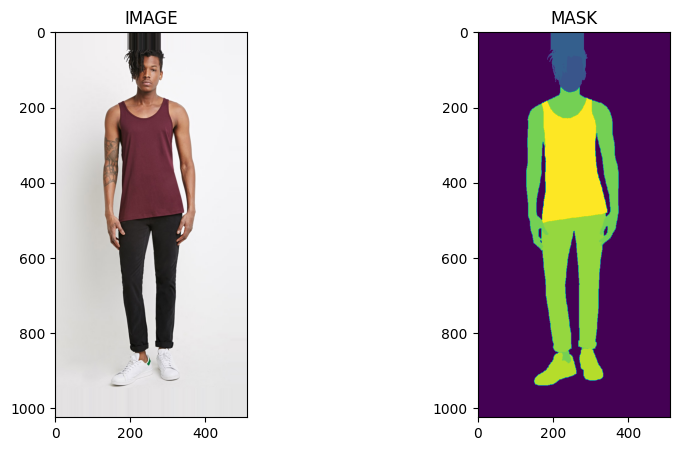

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

### spliter le dataset

In [17]:
train_df , valid_df = train_test_split(df , test_size= 0.2 , random_state=42 )

In [18]:
train_df.shape

(8268, 2)

### Redimentionner les images

In [19]:
imageR = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
maskR = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)


In [20]:
imageR.shape

(256, 256, 3)

In [21]:
maskR.shape

(256, 256)

## Augmentation de données

In [22]:
import albumentations as A

In [23]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE  , IMG_SIZE ),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_Valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE  , IMG_SIZE ),
  ])


## Créer un ensemble de données personnalisé

In [24]:
from torch.utils.data import Dataset

In [25]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None):
        """
        Args:
            df (DataFrame): DataFrame contenant les chemins d'images et de masques.
            augmentations (albumentations.Compose): Augmentations à appliquer aux images et aux masques.
        """
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        """Retourne la taille du dataset."""
        return len(self.df)

    def __getitem__(self, index):
        """Retourne une paire (image, masque) après éventuelles augmentations."""
        row = self.df.iloc[index]
        image_path = row.image_path
        mask_path = row.mask_path

        # Lecture de l'image et conversion en RGB
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Lecture du masque (en niveaux de gris)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Vérifier les dimensions de l'image et du masque
        if image.shape[:2] != mask.shape:
            # Redimensionner le masque pour qu'il corresponde à l'image si nécessaire
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

        # Appliquer les augmentations si disponibles
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # Changer la dimension de l'image et du masque (h, w, c) -> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        # Torch tensor conversion, normalisation de l'image et arrondi du masque
        image = torch.tensor(image) / 255.0  # Normalisation entre 0 et 1
        mask = torch.tensor(mask).unsqueeze(0).float()  # Ajout d'une dimension pour le masque (1, h, w)

        # Retourne seulement l'image et le masque
        return image, mask


In [26]:
trainset = SegmentationDataset(train_df , get_train_augs())
validset = SegmentationDataset(valid_df , get_Valid_augs())

In [27]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 8268
Size of Validset : 2067


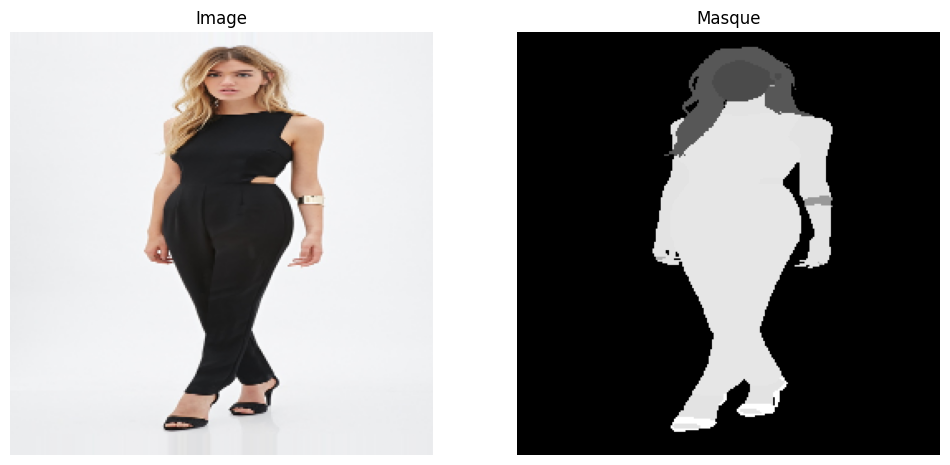

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction d'assistance pour afficher l'image et le masque
def show_image(image, mask):
    # Conversion des tensors en numpy
    image = image.numpy().transpose(1, 2, 0)  # Changement de (c, h, w) à (h, w, c)
    mask = mask.numpy().squeeze()  # Suppression de la dimension supplémentaire (1, h, w) -> (h, w)

    plt.figure(figsize=(12, 6))

    # Affichage de l'image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Affichage du masque
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Masque')
    plt.axis('off')

    plt.show()

# Exemple d'affichage pour un index spécifique
idx = 2  # Choisis l'index que tu veux visualiser
image, mask = trainset[idx]  # Récupération de l'image et du masque
show_image(image, mask)  # Appel de la fonction d'affichage


## Tâche 5 : Charger l'ensemble de données par lots

In [29]:
from torch.utils.data import DataLoader

In [30]:
trainloader = DataLoader(trainset , batch_size=BATCH_SIZE , shuffle = True)
validloader = DataLoader(validset , batch_size=BATCH_SIZE )

In [31]:
print(f"Number of batches in trainloader : {len(trainloader)}")
print(f"Number of batches in validloader : {len(validloader)}" )

Number of batches in trainloader : 517
Number of batches in validloader : 130


In [32]:
for image, mask in trainloader:
    break

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")


Image shape: torch.Size([16, 3, 256, 256])
Mask shape: torch.Size([16, 1, 256, 256])


## Tâche 6 : Créer un modèle de segmentation

In [33]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [49]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        # Architecture UNet avec 12 classes
        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=12,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)  # Sortie du modèle

        if masks is not None:
            # Supprime la dimension supplémentaire pour le masque
            masks = masks.squeeze(1).long()  # Format (N, H, W)

            # Vérifiez les dimensions
            assert masks.size() == logits.size()[0:3], f"Logits size: {logits.size()}, Masks size: {masks.size()}"

            # Utilisation de CrossEntropy pour segmentation multi-classes
            loss = nn.CrossEntropyLoss()(logits, masks)  # Masques déjà en long

            return logits, loss  # Retourne les logits et la perte
        return logits  # Si pas de masque, ne retourne que les logits

def train_fn(trainloader, model, optimizer):
    model.train()
    total_loss = 0.0

    for images, masks in trainloader:
        optimizer.zero_grad()

        images = images.to(device)  # Déplacez les images sur le bon appareil
        masks = masks.to(device)  # Déplacez les masques sur le bon appareil

        outputs, loss = model(images, masks)  # Obtenez les logits et la perte
        loss.backward()  # Rétropropagation
        optimizer.step()  # Mettez à jour les poids

        total_loss += loss.item()

    return total_loss / len(trainloader)  # Retournez la perte moyenne


In [44]:
# Vérifie si un GPU est disponible et utilise-le, sinon utilise le CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialise le modèle
model = SegmentationModel()  # Assurez-vous que cette classe est définie
model.to(device)  # Déplace le modèle vers le GPU


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

#### Trouver le nombre de classe à utiliser


In [51]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        # Architecture UNet avec 12 classes
        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=12,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)  # Sortie du modèle

        if masks is not None:
            # Supprime la dimension supplémentaire pour le masque
            masks = masks.squeeze(1).long()  # Format (N, H, W)

            # Vérifiez que les dimensions correspondent
            if masks.size(0) != logits.size(0) or masks.size(1) != logits.size(2) or masks.size(2) != logits.size(3):
                raise ValueError(f"Logits size: {logits.size()}, Masks size: {masks.size()}")

            # Utilisation de CrossEntropy pour segmentation multi-classes
            loss = nn.CrossEntropyLoss()(logits, masks)  # Masques déjà en long

            return logits, loss  # Retourne les logits et la perte
        return logits  # Si pas de masque, ne retourne que les logits

def train_fn(trainloader, model, optimizer):
    model.train()
    total_loss = 0.0

    for images, masks in trainloader:
        optimizer.zero_grad()

        images = images.to(device)  # Déplacez les images sur le bon appareil
        masks = masks.to(device)  # Déplacez les masques sur le bon appareil

        outputs, loss = model(images, masks)  # Obtenez les logits et la perte
        loss.backward()  # Rétropropagation
        optimizer.step()  # Mettez à jour les poids

        total_loss += loss.item()

    return total_loss / len(trainloader)  # Retournez la perte moyenne


## Task 7 : Create Train and Validation Function

In [57]:
if (masks < 0).any() or (masks >= 12).any():
    raise ValueError(f"Masques contiennent des valeurs invalides : {masks}")


NameError: name 'masks' is not defined

In [54]:
def train_fn(trainloader, model, optimizer):
    model.train()
    total_loss = 0.0

    for images, masks in trainloader:
        optimizer.zero_grad()

        images = images.to(device)  # Déplacez les images sur le bon appareil
        masks = masks.to(device)  # Déplacez les masques sur le bon appareil

        # Vérifiez les valeurs dans les masques
        if (masks < 0).any() or (masks >= 12).any():
            raise ValueError(f"Masques contiennent des valeurs invalides: {masks}")

        outputs, loss = model(images, masks)  # Obtenez les logits et la perte
        loss.backward()  # Rétropropagation
        optimizer.step()  # Mettez à jour les poids

        total_loss += loss.item()

    return total_loss / len(trainloader)  # Retournez la perte moyenne


In [46]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(data_loader)

## Task 8 : Train Model

In [47]:
# Initialisation de l'optimiseur
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [55]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [56]:
# Entraînement et validation
best_validation_loss = np.inf

for i in range(EPOCHS):
    # Entraînement du modèle
    train_loss = train_fn(trainloader, model, optimizer)

    # Évaluation du modèle
    valid_loss = eval_fn(validloader, model)

    # Sauvegarde du meilleur modèle
    if valid_loss < best_validation_loss:
        torch.save(model.state_dict(), "best_model.pth")
        print("SAVED MODEL")
        best_validation_loss = valid_loss

    # Affichage des pertes
    print(f"Epoch: {i + 1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
